In [4]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
appName="Recommender with collaborative Filtering"

#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

#get sparkcontext from the sparksession
sc = spark.sparkContext
sqlContext = SQLContext(sc)


c:\Users\ander\Envs\recommendation\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [8]:
df_song = sqlContext.read.csv('./data/spotify_dataset.csv', header=True,inferSchema = True)
# df_review = sqlContext.read.json('./yelp_data/yelp_academic_dataset_review.json')

In [9]:
df_song.show(1)

+--------------------+--------------+--------------------+---------------+
|             user_id|  "artistname"|         "trackname"| "playlistname"|
+--------------------+--------------+--------------------+---------------+
|9cc0cfd4d7d788510...|Elvis Costello|(The Angels Wanna...| HARD ROCK 2010|
+--------------------+--------------+--------------------+---------------+
only showing top 1 row



In [54]:
df_business.show(1)

+--------------------+--------------------+--------------------+--------------------+-------------+-----+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+-----+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara| null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
+--------------------+--------------------+--------------------+--------------------+-------------+-----+-------+----------+------------+--------------------+-----------+------------+-----+-----+
only showing top 1 r

In [56]:
cities = df_business.groupby('city').count().orderBy(col('count').desc())
cities.show()

+----------------+-----+
|            city|count|
+----------------+-----+
|    Philadelphia|14569|
|          Tucson| 9250|
|           Tampa| 9050|
|    Indianapolis| 7540|
|       Nashville| 6971|
|     New Orleans| 6209|
|            Reno| 5935|
|        Edmonton| 5054|
|     Saint Louis| 4827|
|   Santa Barbara| 3829|
|           Boise| 2937|
|      Clearwater| 2221|
|Saint Petersburg| 1663|
|        Metairie| 1643|
|          Sparks| 1624|
|      Wilmington| 1446|
|        Franklin| 1414|
|       St. Louis| 1255|
|  St. Petersburg| 1185|
|        Meridian| 1043|
+----------------+-----+
only showing top 20 rows



In [ ]:
rename_col = [f"{e}_b" for e in data.columns]

In [57]:
df_business = df_business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_b")



In [58]:
df_business = df_business.filter((df_business['city'] == 'Tucson') & (df_business.categories.contains('Restaurants'))).drop('city')

In [59]:
df_review = df_review.join(df_business, on='business_id', how='inner')

In [60]:
df_review.show(1)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+-------+------------+--------------------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|                name|stars_b|review_count|          attributes|          categories|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+-------+------------+--------------------+--------------------+
|I0053JmJ5DEFUWSJ8...|   1|2012-05-28 22:54:46|    1|y3fnE9QQnSqMzOTFq...|  4.0|What else can I s...|     1|_VTkMoIa11C9IA4zl...|Golden Corral Buf...|    2.5|          84|{null, null, u'no...|Buffets, Restaura...|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+---------------

In [62]:
df_review.select(['business_id', 'user_id', 'stars', 'stars_b']).show(1)

+--------------------+--------------------+-----+-------+
|         business_id|             user_id|stars|stars_b|
+--------------------+--------------------+-----+-------+
|YjUWPpI6HXG530lwP...|8g_iMtfSiwikVnbP2...|  3.0|    3.5|
+--------------------+--------------------+-----+-------+
only showing top 1 row



C:\Users\ander\AppData\Local\Temp\ipykernel_17980\3837168525.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


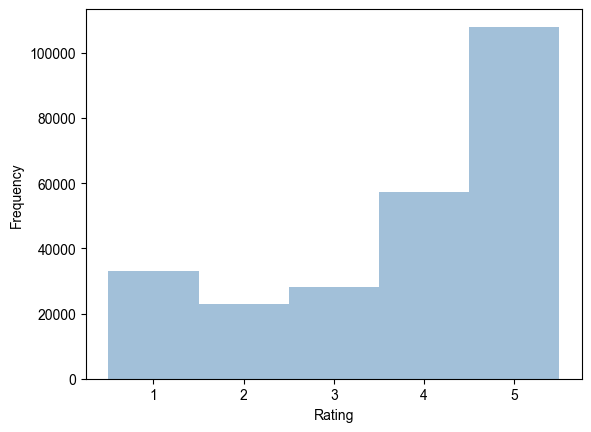

In [63]:
reviews = df_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

C:\Users\ander\AppData\Local\Temp\ipykernel_17980\1739598986.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


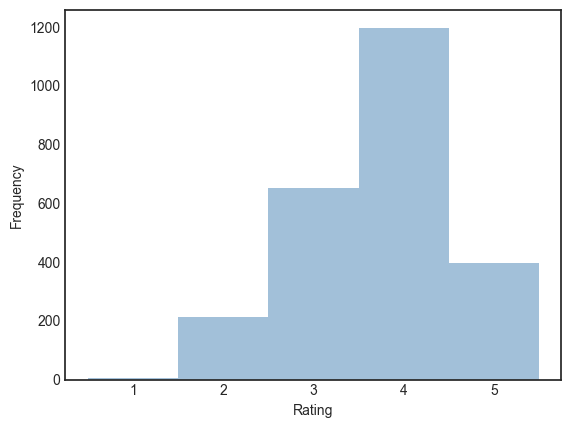

In [65]:
restaurant_reviews = df_business.select('stars_b').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]


plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [66]:
restaurant_categories = df_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]

In [67]:
text = " ".join(review for review in restaurant_categories_list)

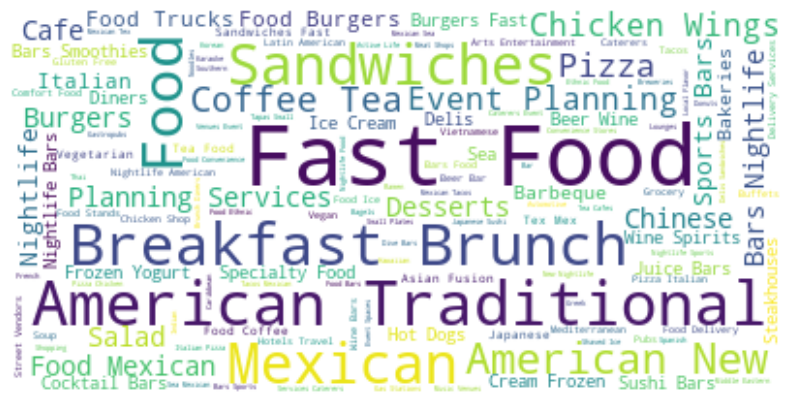

In [68]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [69]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_review).transform(df_review)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

DataFrame[business_id: string, user_id: string, business_id_index: double, user_id_index: double]

In [70]:
(training, test) = transformed.randomSplit([0.8, 0.2])

In [71]:
als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)



In [72]:
model=als.fit(training)

In [ ]:
model_path = + "./model/als"
model.save(model_path)

In [ ]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

In [ ]:
test = model.recommendForAllUsers(20).filter(col('user_id_index')==30).select("recommendations").collect()
topRestaurants = []
for item in test[0][0]:        
    topRestaurants.append(item.business_id_index)
    
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")


transformed\
.select(['business_id', 'user_id', 'stars', 'categories'])\
.filter(col('user_id_index')==30)\
.show()

restaurants\
.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'categories', 'name'])\
.drop_duplicates(subset=['name'])\
.show()



In [ ]:
import pickle
